In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import os
if not os.getcwd().endswith('CIoTS'):
    os.chdir('../..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from CIoTS import *
import networkx as nx

In [3]:
from itertools import product

dimensions = [3, 5]
incoming_edges = [2, 3, 4]
taus = [5, 10, 15, 20]
autocorrs = [False, True]
data_length = [10000]
# runs = range(10)

setups = list(product(dimensions, incoming_edges, taus, autocorrs, data_length))#, runs))

In [ ]:
import pickle


def graph2Var(graph, dim, tau, mapping):
    inverted_mapping = {v: k for k, v in mapping.items()}
    params = np.zeros((dim * tau, dim))

    for x_t in range(dim):
        input_nodes = list(graph.predecessors(mapping[x_t]))
        inputs = np.array([inverted_mapping[x] for x in input_nodes])
        for i in inputs:
            params[i - dim, x_t] = graph.edges[(mapping[i], mapping[x_t])]['weight']
    return params

data_path = 'notebooks/ICML/icml_data_v2/'
results_path = 'notebooks/ICML/icml_results_v2/'
results = pd.DataFrame()

names = ['PC1 incremental', 'PC extensive', 'PC incremental', 'PCMCI incremental']

for dim, in_edges, tau, autocorr, _, run in setups:
    generator = pickle.load(open(data_path + f't={tau}_d={dim}_in={in_edges}_autocorr={autocorr}_{run}.pickle', 'rb'))
    algo_graphs = pickle.load(open(results_path + 'exp3_graphs/' + 
                                   f'graphs-t={tau}_d={dim}_in={in_edges}_autocorr={autocorr}_{run}.pickle', 'rb'))
    max_tau = 2*tau
    df_dict = {'dimension': [dim]*max_tau, 'max time lag': [tau]*max_tau, 'incoming edges': [in_edges]*max_tau, 
               'run': [run]*max_tau, 'autocorr': [autocorr]*max_tau, 'tau estimate': list(range(1, max_tau+1))}
    
    true_mapping, true_matrix = transform_ts(generator.ts, tau)
    true_params = graph2Var(generator.graph, dim, tau, true_mapping)
    
    # each algorithm
    for name in names:
        df_dict[name] = []
        graphs = algo_graphs[name]
        
        assert len(graphs) == max_tau
        for est_tau, graph in graphs.items():
            model = VAR(est_tau)
            node_mapping, data_matrix = transform_ts(generator.ts, est_tau)
            model.fit_from_graph(dim, data_matrix, graph, node_mapping)
            est_params = model.params[1:]
            df_dict[name].append(evaluate_parameters(true_params, est_params))
    
    # VAR for different tau'
    df_dict['complete VAR'] = []
    for est_tau in range(1, max_tau+1):
        model = VAR(est_tau)
        model.fit(generator.ts)
        est_params = model.params[1:]
        df_dict['complete VAR'].append(evaluate_parameters(true_params, est_params))
    
    # True Graph VAR
    model = VAR(tau)
    model.fit_from_graph(dim, true_matrix, generator.graph, true_mapping)
    est_params = model.params[1:]
    df_dict['true Graph'] = [evaluate_parameters(true_params, est_params)] * max_tau
    
    df = pd.DataFrame(df_dict)
    results = results.append(df)
    
#     results.to_csv(results_path + f'experiment4.csv', index=False)
    

## Evaluation

In [5]:
results_path = 'notebooks/ICML/icml_results_v2/'
results3 = pd.read_csv(results_path + 'experiment3.csv')
results3 = results3[results3.dimension != 10]
results3

,dimension,max time lag,incoming edges,run,autocorr,tau estimate,PC incremental_tn,PC incremental_fp,PC incremental_tp,PC incremental_fn,...,PC1 incremental_f1,PC1 incremental_bics,PC1 incremental_added_edges,PCMCI incremental_tn,PCMCI incremental_fp,PCMCI incremental_tp,PCMCI incremental_fn,PCMCI incremental_f1,PCMCI incremental_bics,PCMCI incremental_added_edges
0,3,5,2,0,False,1,6,2,1,0,...,0.200000,-3.105275,3,5,3,1,0,0.200000,-3.105275,3
1,3,5,2,0,False,2,13,4,1,0,...,0.181818,-3.547400,1,14,3,1,0,0.200000,-3.121102,0
2,3,5,2,0,False,3,19,6,1,1,...,0.153846,-4.418851,2,21,4,2,0,0.333333,-4.230031,2
3,3,5,2,0,False,4,25,8,2,1,...,0.266667,-5.221047,2,33,0,3,0,0.666667,-5.472146,1
4,3,5,2,0,False,5,34,5,4,2,...,0.461538,-14.087442,2,39,0,4,2,0.800000,-14.623780,1
5,3,5,2,0,False,6,42,6,4,2,...,0.428571,-14.536765,0,48,0,4,2,0.800000,-14.688793,0
6,3,5,2,0,False,7,51,6,4,2,...,0.428571,-14.568512,0,57,0,4,2,0.800000,-14.720236,0
7,3,5,2,0,False,8,60,6,3,3,...,0.428571,-14.640464,0,66,0,4,2,0.800000,-14.792159,0
8,3,5,2,0,False,9,68,7,3,3,...,0.428571,-14.636434,0,75,0,4,2,0.800000,-14.788260,0
9,3,5,2,0,False,10,76,8,2,4,...,0.428571,-15.515765,1,83,1,4,2,0.727273,-21.587404,1


In [6]:
results4 = pd.read_csv(results_path + 'experiment4.csv')
results4

,dimension,max time lag,incoming edges,run,autocorr,tau estimate,PC1 incremental,PC extensive,PC incremental,PCMCI incremental,complete VAR,true Graph
0,3,5,2,0,False,1,0.985786,0.980705,0.980705,0.985786,1.146654e+00,0.000085
1,3,5,2,0,False,2,1.695676,1.695676,1.695676,0.981495,4.758795e+00,0.000085
2,3,5,2,0,False,3,1.063192,1.063192,1.063192,0.886011,5.374751e+00,0.000085
3,3,5,2,0,False,4,0.821886,0.892397,0.892397,0.480012,5.391958e+00,0.000085
4,3,5,2,0,False,5,0.629988,0.723870,0.723870,0.320030,1.033337e+00,0.000085
5,3,5,2,0,False,6,0.707614,0.855883,0.855883,0.320030,3.812054e-01,0.000085
6,3,5,2,0,False,7,0.707517,0.855540,0.855540,0.320028,2.781598e-01,0.000085
7,3,5,2,0,False,8,0.707579,1.077860,1.077860,0.320028,2.775196e-01,0.000085
8,3,5,2,0,False,9,0.707651,1.088747,1.088747,0.320027,3.599492e-01,0.000085
9,3,5,2,0,False,10,0.676146,1.068476,1.065328,0.344787,8.351200e-01,0.000085


In [ ]:
# plt_data = results4[(results4[['dimension', 'incoming edges', 'max time lag',
#                                'autocorr', 'run']].values == (dim, in_edges, tau, autocorr, run)).all(axis=1)]

In [15]:
len(results4.groupby([
    'dimension', 'incoming edges', 'max time lag']))

24

{'dimension': 3, 'max time lag': 5, 'edges': 2, 'autocorr': False, 'VAR_tau-1_SE': 3.0449167994772717, 'VAR_tau_SE': 0.2709560378736099, 'VAR_tau+1_SE': 0.3441206820906363, 'PCMCI incremental_SE': 0.5276317324221769}


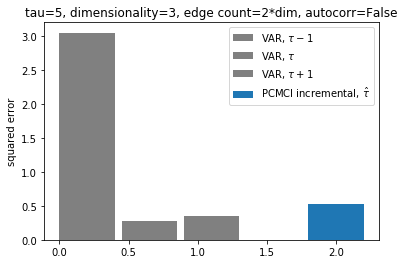

{'dimension': 3, 'max time lag': 5, 'edges': 2, 'autocorr': True, 'VAR_tau-1_SE': 5.050684038296304, 'VAR_tau_SE': 1.6206923388603616, 'VAR_tau+1_SE': 0.9966623391787298, 'PCMCI incremental_SE': 0.9258399006838758}


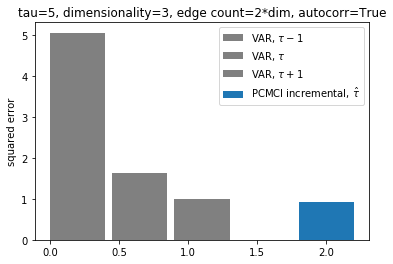

{'dimension': 3, 'max time lag': 10, 'edges': 2, 'autocorr': False, 'VAR_tau-1_SE': 6.211821284232635e+23, 'VAR_tau_SE': 5.890952809506752e+23, 'VAR_tau+1_SE': 4.908656963658908e+20, 'PCMCI incremental_SE': 0.6250179569565602}


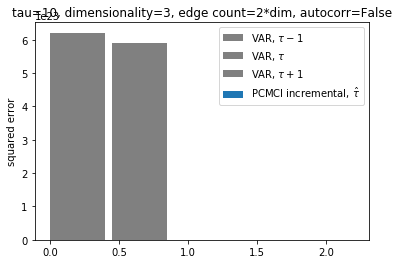

{'dimension': 3, 'max time lag': 10, 'edges': 2, 'autocorr': True, 'VAR_tau-1_SE': 9.364787290478409e+23, 'VAR_tau_SE': 4.146892614691492e+23, 'VAR_tau+1_SE': 1.856324026088369e+24, 'PCMCI incremental_SE': 0.775973371188176}


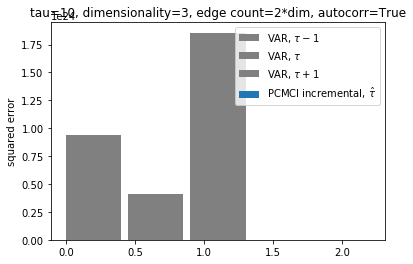

{'dimension': 3, 'max time lag': 15, 'edges': 2, 'autocorr': False, 'VAR_tau-1_SE': 1.9548071037089645e+24, 'VAR_tau_SE': 1.4141106044764347e+24, 'VAR_tau+1_SE': 3.062915058877884e+24, 'PCMCI incremental_SE': 0.9345136005743194}


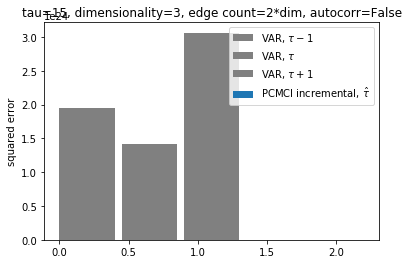

{'dimension': 3, 'max time lag': 15, 'edges': 2, 'autocorr': True, 'VAR_tau-1_SE': 2.4610704610433636e+23, 'VAR_tau_SE': 6.195284704081014e+23, 'VAR_tau+1_SE': 5.4441545173901924e+23, 'PCMCI incremental_SE': 0.8384036389398826}


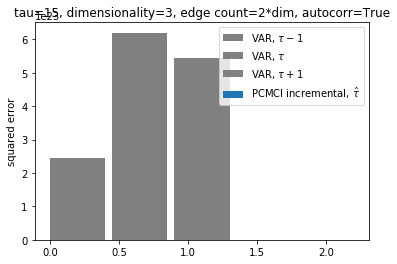

{'dimension': 3, 'max time lag': 20, 'edges': 2, 'autocorr': False, 'VAR_tau-1_SE': 6.501637488055714e+23, 'VAR_tau_SE': 4.645062244873473e+24, 'VAR_tau+1_SE': 7.551035215088237e+24, 'PCMCI incremental_SE': 1.1277334990035746}


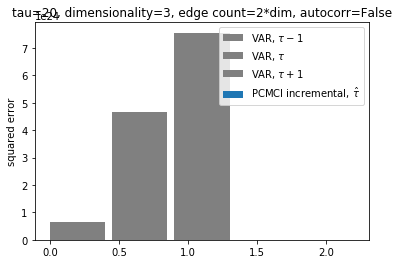

{'dimension': 3, 'max time lag': 20, 'edges': 2, 'autocorr': True, 'VAR_tau-1_SE': 2.0283863770691942e+24, 'VAR_tau_SE': 6.507609913629703e+24, 'VAR_tau+1_SE': 2.2693868177983e+24, 'PCMCI incremental_SE': 1.1114242130073257}


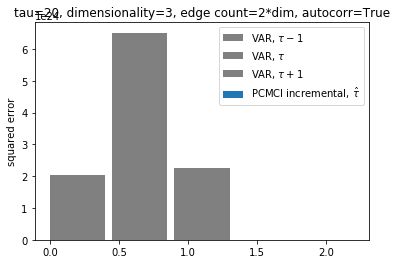

{'dimension': 3, 'max time lag': 5, 'edges': 3, 'autocorr': False, 'VAR_tau-1_SE': 5.424601742450271, 'VAR_tau_SE': 3.621043689252514, 'VAR_tau+1_SE': 2.0055803893531534, 'PCMCI incremental_SE': 0.43872000847425713}


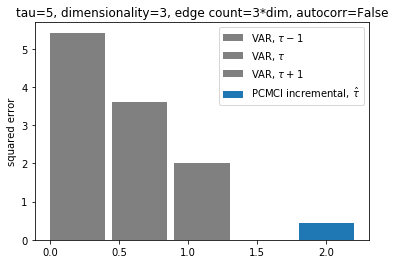

{'dimension': 3, 'max time lag': 5, 'edges': 3, 'autocorr': True, 'VAR_tau-1_SE': 11.08633578988488, 'VAR_tau_SE': 6.107737049288904, 'VAR_tau+1_SE': 1.6738107569935685, 'PCMCI incremental_SE': 0.9959672694349063}


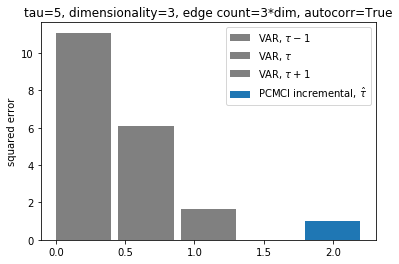

{'dimension': 3, 'max time lag': 10, 'edges': 3, 'autocorr': False, 'VAR_tau-1_SE': 3.9851095486608314, 'VAR_tau_SE': 1.414937584750464, 'VAR_tau+1_SE': 3.9136741977752726e+23, 'PCMCI incremental_SE': 1.3432879755745257}


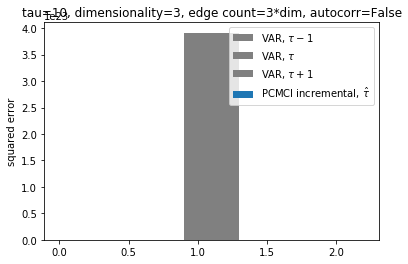

{'dimension': 3, 'max time lag': 10, 'edges': 3, 'autocorr': True, 'VAR_tau-1_SE': 2.2604759358935904e+22, 'VAR_tau_SE': 5.1139103503553646e+20, 'VAR_tau+1_SE': 3.673245499896498e+23, 'PCMCI incremental_SE': 1.6042372040655177}


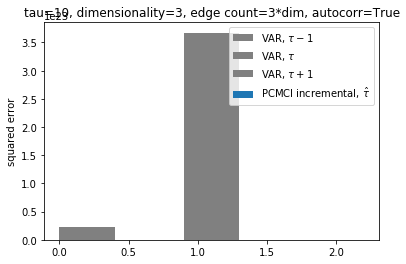

{'dimension': 3, 'max time lag': 15, 'edges': 3, 'autocorr': False, 'VAR_tau-1_SE': 378.5420155190995, 'VAR_tau_SE': 1.8410432636140713e+24, 'VAR_tau+1_SE': 3.464246598317666e+23, 'PCMCI incremental_SE': 1.130055117357407}


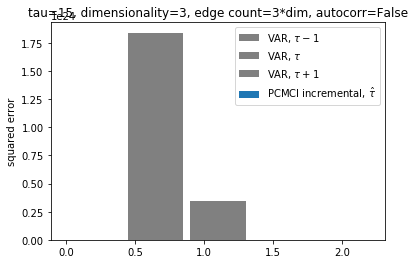

{'dimension': 3, 'max time lag': 15, 'edges': 3, 'autocorr': True, 'VAR_tau-1_SE': 2.1385682705140167e+22, 'VAR_tau_SE': 6.881069854134736e+22, 'VAR_tau+1_SE': 2.0299892221537593e+22, 'PCMCI incremental_SE': 1.6217168433256952}


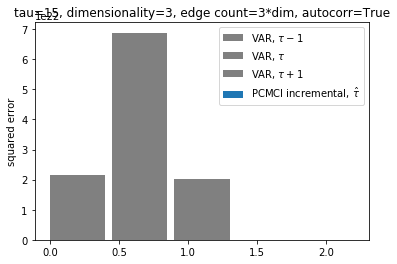

{'dimension': 3, 'max time lag': 20, 'edges': 3, 'autocorr': False, 'VAR_tau-1_SE': 4.747688669170474e+23, 'VAR_tau_SE': 1.685487315423715e+24, 'VAR_tau+1_SE': 2.888796554321775e+24, 'PCMCI incremental_SE': 0.9622545893733234}


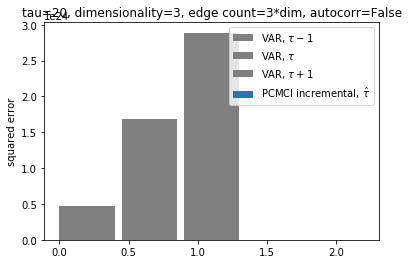

{'dimension': 3, 'max time lag': 20, 'edges': 3, 'autocorr': True, 'VAR_tau-1_SE': 3.5842881921043617e+24, 'VAR_tau_SE': 9.930353573466188e+23, 'VAR_tau+1_SE': 3.7861896683635896e+24, 'PCMCI incremental_SE': 1.5769085884534166}


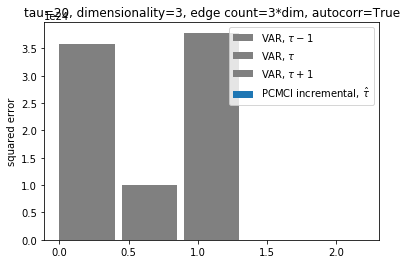

{'dimension': 3, 'max time lag': 5, 'edges': 4, 'autocorr': False, 'VAR_tau-1_SE': 6.882968598711818, 'VAR_tau_SE': 0.4296957250891869, 'VAR_tau+1_SE': 0.48152837654148595, 'PCMCI incremental_SE': 0.9793631255470954}


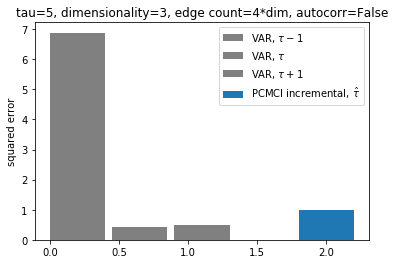

{'dimension': 3, 'max time lag': 5, 'edges': 4, 'autocorr': True, 'VAR_tau-1_SE': 8.942749668732194, 'VAR_tau_SE': 2.5444353196211913, 'VAR_tau+1_SE': 2.0557431562373405, 'PCMCI incremental_SE': 1.7975806644431516}


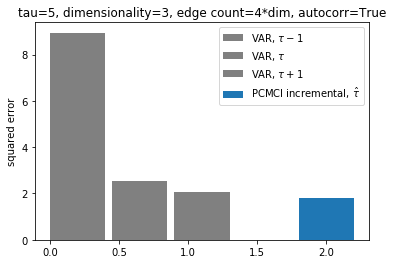

{'dimension': 3, 'max time lag': 10, 'edges': 4, 'autocorr': False, 'VAR_tau-1_SE': 5.005525189550758, 'VAR_tau_SE': 6.55348361445318e+23, 'VAR_tau+1_SE': 7.789564717564149e+22, 'PCMCI incremental_SE': 1.7880461290967624}


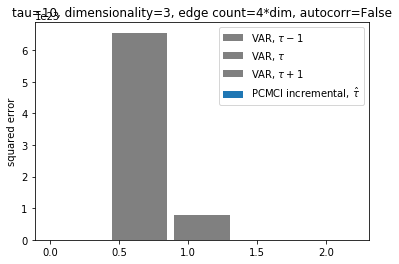

{'dimension': 3, 'max time lag': 10, 'edges': 4, 'autocorr': True, 'VAR_tau-1_SE': 13.636281328607955, 'VAR_tau_SE': 6.161424036746799e+22, 'VAR_tau+1_SE': 8.629223224486153e+21, 'PCMCI incremental_SE': 1.891288783780156}


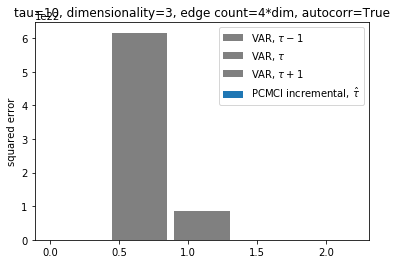

{'dimension': 3, 'max time lag': 15, 'edges': 4, 'autocorr': False, 'VAR_tau-1_SE': 26.853599769349508, 'VAR_tau_SE': 4.1358698565046013e+23, 'VAR_tau+1_SE': 1.456238406762158e+22, 'PCMCI incremental_SE': 1.1300216881589111}


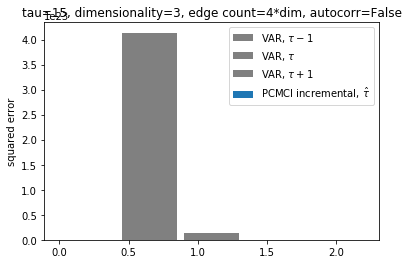

{'dimension': 3, 'max time lag': 15, 'edges': 4, 'autocorr': True, 'VAR_tau-1_SE': 2.9990502543516013e+23, 'VAR_tau_SE': 1.6560799459871551e+22, 'VAR_tau+1_SE': 2.7200547391229146e+23, 'PCMCI incremental_SE': 1.7312203384454818}


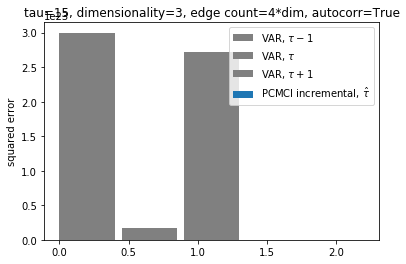

{'dimension': 3, 'max time lag': 20, 'edges': 4, 'autocorr': False, 'VAR_tau-1_SE': 2.3119929719159868e+24, 'VAR_tau_SE': 5.867920731347008e+22, 'VAR_tau+1_SE': 5.349387112444722e+24, 'PCMCI incremental_SE': 1.2638054959349536}


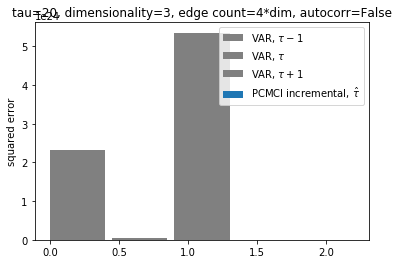

{'dimension': 3, 'max time lag': 20, 'edges': 4, 'autocorr': True, 'VAR_tau-1_SE': 4.2748804342437897e+24, 'VAR_tau_SE': 2.3926454467128774e+22, 'VAR_tau+1_SE': 2.2157035767608437e+24, 'PCMCI incremental_SE': 1.4492734645647756}


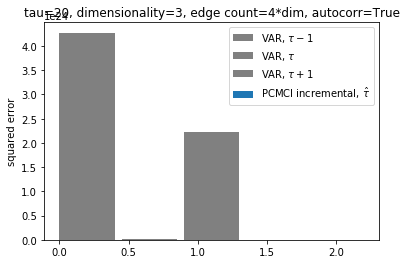

{'dimension': 5, 'max time lag': 5, 'edges': 2, 'autocorr': False, 'VAR_tau-1_SE': 42.657840517677826, 'VAR_tau_SE': 122.70775544808775, 'VAR_tau+1_SE': 414.33776516796206, 'PCMCI incremental_SE': 0.6416997519052645}


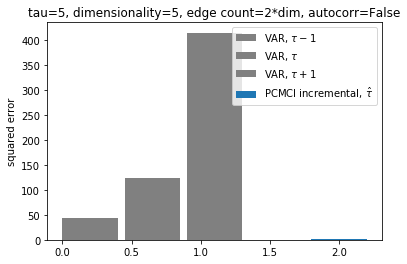

{'dimension': 5, 'max time lag': 5, 'edges': 2, 'autocorr': True, 'VAR_tau-1_SE': 22.307607644820838, 'VAR_tau_SE': 3.54347177101126e+16, 'VAR_tau+1_SE': 1.2372813898427654e+16, 'PCMCI incremental_SE': 3.314466260811146}


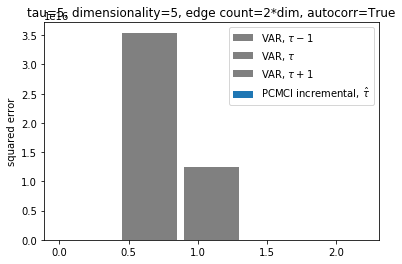

{'dimension': 5, 'max time lag': 10, 'edges': 2, 'autocorr': False, 'VAR_tau-1_SE': 7.2599152284034e+23, 'VAR_tau_SE': 1.482627417762804e+24, 'VAR_tau+1_SE': 5.495103933832583e+23, 'PCMCI incremental_SE': 1.072039917214999}


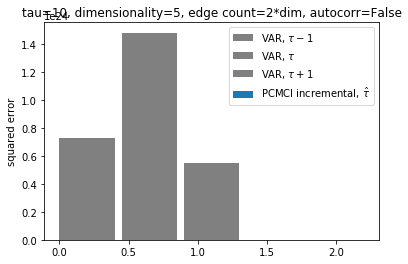

{'dimension': 5, 'max time lag': 10, 'edges': 2, 'autocorr': True, 'VAR_tau-1_SE': 1.5775371966522502e+23, 'VAR_tau_SE': 1.4423412487706872e+24, 'VAR_tau+1_SE': 2.2681086968401053e+24, 'PCMCI incremental_SE': 2.0655963739508487}


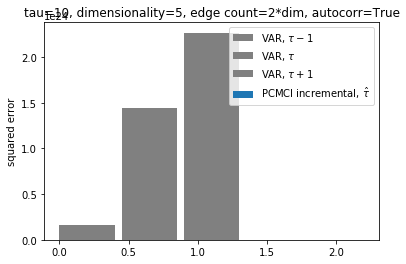

{'dimension': 5, 'max time lag': 15, 'edges': 2, 'autocorr': False, 'VAR_tau-1_SE': 2.9355808995920016e+24, 'VAR_tau_SE': 4.168988683655053e+24, 'VAR_tau+1_SE': 5.740131682004891e+24, 'PCMCI incremental_SE': 1.8637528628037328}


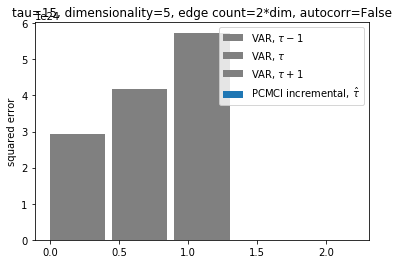

{'dimension': 5, 'max time lag': 15, 'edges': 2, 'autocorr': True, 'VAR_tau-1_SE': 3.738973251076789e+23, 'VAR_tau_SE': 4.5835647681196435e+22, 'VAR_tau+1_SE': 5.748703391246369e+24, 'PCMCI incremental_SE': 1.6832453299333434}


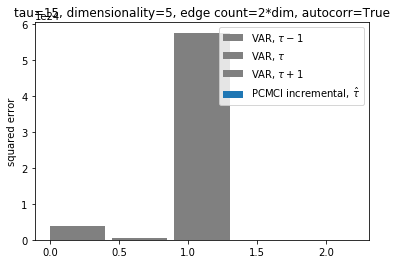

{'dimension': 5, 'max time lag': 20, 'edges': 2, 'autocorr': False, 'VAR_tau-1_SE': 3.336817288288509e+24, 'VAR_tau_SE': 7.600434126347582e+24, 'VAR_tau+1_SE': 9.59891925773308e+24, 'PCMCI incremental_SE': 1.659402242638727}


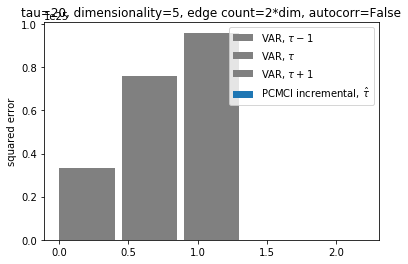

{'dimension': 5, 'max time lag': 20, 'edges': 2, 'autocorr': True, 'VAR_tau-1_SE': 3.2820002218392977e+25, 'VAR_tau_SE': 4.1333739662820856e+24, 'VAR_tau+1_SE': 6.758498877679107e+24, 'PCMCI incremental_SE': 2.21192804676421}


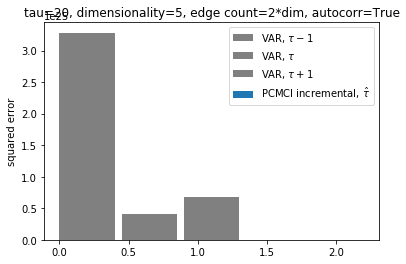

{'dimension': 5, 'max time lag': 5, 'edges': 3, 'autocorr': False, 'VAR_tau-1_SE': 32.24044868490687, 'VAR_tau_SE': 1.0864382300742763e+22, 'VAR_tau+1_SE': 1.0582045109179442e+24, 'PCMCI incremental_SE': 4.875299090651128}


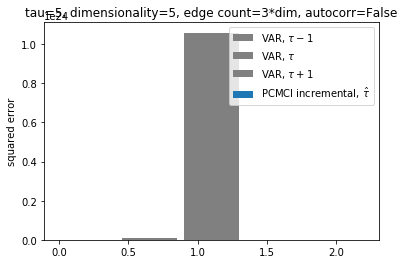

{'dimension': 5, 'max time lag': 5, 'edges': 3, 'autocorr': True, 'VAR_tau-1_SE': 21.45129353856067, 'VAR_tau_SE': 164.90738321867605, 'VAR_tau+1_SE': 1.7490014734654238e+24, 'PCMCI incremental_SE': 3.1098453552249135}


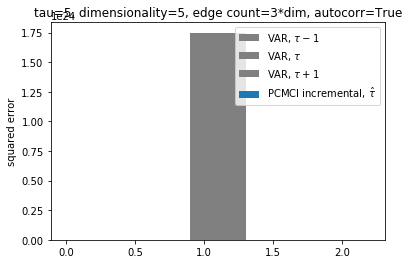

{'dimension': 5, 'max time lag': 10, 'edges': 3, 'autocorr': False, 'VAR_tau-1_SE': 2.4533483046761716e+23, 'VAR_tau_SE': 1.4298494884951697e+24, 'VAR_tau+1_SE': 5.7890709882040465e+23, 'PCMCI incremental_SE': 1.5870311012398484}


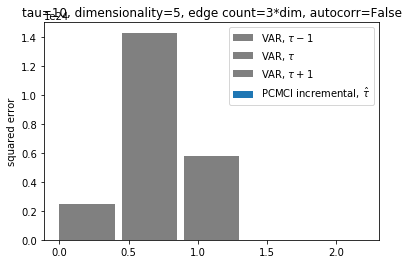

{'dimension': 5, 'max time lag': 10, 'edges': 3, 'autocorr': True, 'VAR_tau-1_SE': 959.265937907043, 'VAR_tau_SE': 6.914438233814338e+20, 'VAR_tau+1_SE': 2.946113207571969e+22, 'PCMCI incremental_SE': 2.896229831096581}


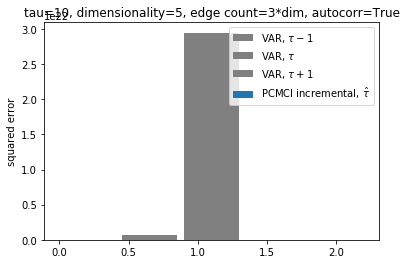

{'dimension': 5, 'max time lag': 15, 'edges': 3, 'autocorr': False, 'VAR_tau-1_SE': 1.1898572763670182e+24, 'VAR_tau_SE': 2.7613998978154595e+24, 'VAR_tau+1_SE': 5.190238018223993e+24, 'PCMCI incremental_SE': 2.106952644295143}


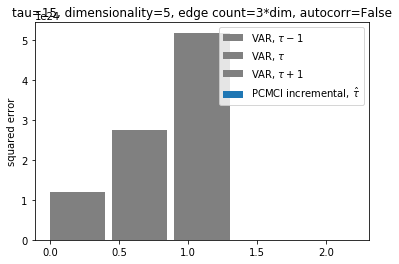

{'dimension': 5, 'max time lag': 15, 'edges': 3, 'autocorr': True, 'VAR_tau-1_SE': 3.5174567145294135e+23, 'VAR_tau_SE': 4.6794306871704345e+23, 'VAR_tau+1_SE': 1.0103069349887594e+24, 'PCMCI incremental_SE': 1.7350836092893733}


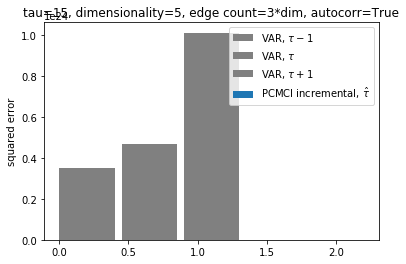

{'dimension': 5, 'max time lag': 20, 'edges': 3, 'autocorr': False, 'VAR_tau-1_SE': 1.7651952518548838e+25, 'VAR_tau_SE': 2.555963865224667e+24, 'VAR_tau+1_SE': 3.434501514615498e+23, 'PCMCI incremental_SE': 1.8392172369500313}


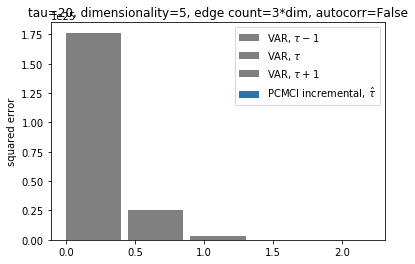

{'dimension': 5, 'max time lag': 20, 'edges': 3, 'autocorr': True, 'VAR_tau-1_SE': 9.818579184050931e+23, 'VAR_tau_SE': 1.444562086232789e+24, 'VAR_tau+1_SE': 3.603494466879932e+23, 'PCMCI incremental_SE': 2.477218837150773}


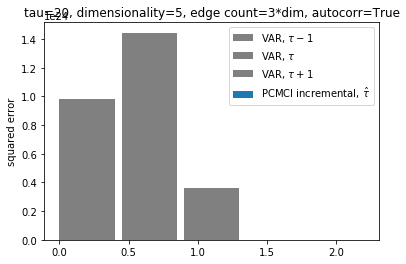

{'dimension': 5, 'max time lag': 5, 'edges': 4, 'autocorr': False, 'VAR_tau-1_SE': 27.08822023412087, 'VAR_tau_SE': 1042.3689649180378, 'VAR_tau+1_SE': 6.681060390978323e+22, 'PCMCI incremental_SE': 2.33602525238629}


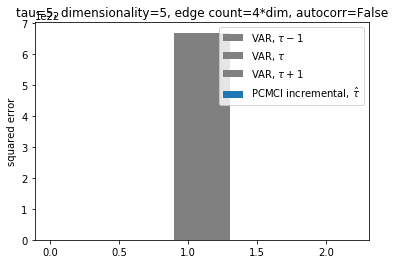

{'dimension': 5, 'max time lag': 5, 'edges': 4, 'autocorr': True, 'VAR_tau-1_SE': 55.43849713276942, 'VAR_tau_SE': 1001.3892525205802, 'VAR_tau+1_SE': 2.2943457907975775e+23, 'PCMCI incremental_SE': 3.8038999106366504}


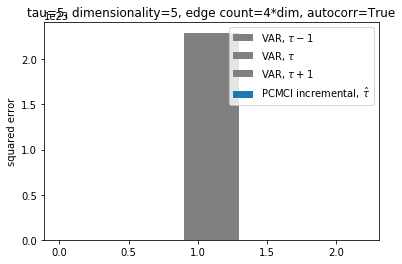

{'dimension': 5, 'max time lag': 10, 'edges': 4, 'autocorr': False, 'VAR_tau-1_SE': 3.114323092117249e+22, 'VAR_tau_SE': 4.327061337596286e+23, 'VAR_tau+1_SE': 4.481922570748283e+23, 'PCMCI incremental_SE': 1.4362598004839935}


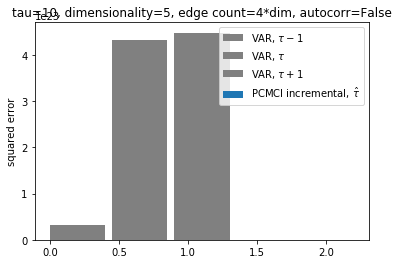

{'dimension': 5, 'max time lag': 10, 'edges': 4, 'autocorr': True, 'VAR_tau-1_SE': 1310.1246201693903, 'VAR_tau_SE': 8655.791646529566, 'VAR_tau+1_SE': 32372.961240738736, 'PCMCI incremental_SE': 2.938087303871986}


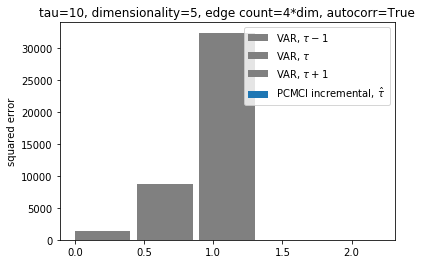

{'dimension': 5, 'max time lag': 15, 'edges': 4, 'autocorr': False, 'VAR_tau-1_SE': 7.308774032839876e+23, 'VAR_tau_SE': 5.520893559203881e+24, 'VAR_tau+1_SE': 1.0148953992118279e+25, 'PCMCI incremental_SE': 1.9975403515072334}


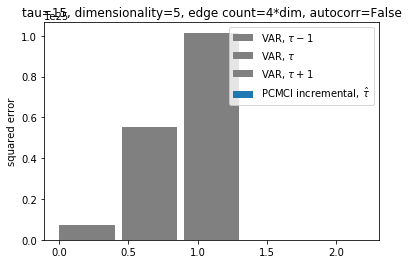

{'dimension': 5, 'max time lag': 15, 'edges': 4, 'autocorr': True, 'VAR_tau-1_SE': 1.3627140390236051e+23, 'VAR_tau_SE': 4.829651595846011e+23, 'VAR_tau+1_SE': 1.1077307473321796e+24, 'PCMCI incremental_SE': 3.437935669728833}


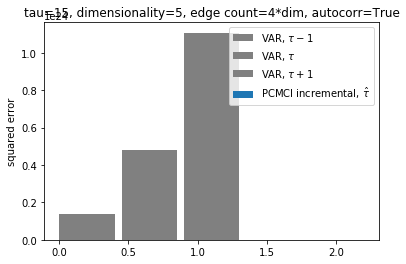

{'dimension': 5, 'max time lag': 20, 'edges': 4, 'autocorr': False, 'VAR_tau-1_SE': 5.939146230545419e+24, 'VAR_tau_SE': 5.949601582059363e+23, 'VAR_tau+1_SE': 4.6768365474197006e+24, 'PCMCI incremental_SE': 2.356908162511226}


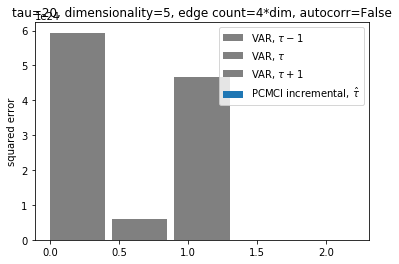

{'dimension': 5, 'max time lag': 20, 'edges': 4, 'autocorr': True, 'VAR_tau-1_SE': 1.8027970914897088e+24, 'VAR_tau_SE': 1.0959458739685679e+22, 'VAR_tau+1_SE': 1.3624035765353414e+23, 'PCMCI incremental_SE': 2.0632187727227107}


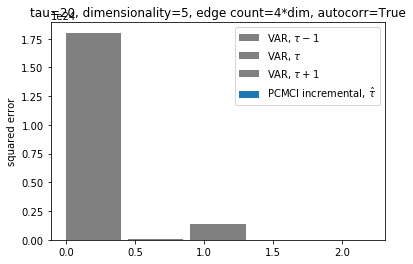

,dimension,max time lag,edges,autocorr,VAR_tau-1_SE,VAR_tau_SE,VAR_tau+1_SE,PCMCI incremental_SE
0,3,5,2,False,3.044917e+00,2.709560e-01,3.441207e-01,0.527632
0,3,5,2,True,5.050684e+00,1.620692e+00,9.966623e-01,0.925840
0,3,10,2,False,6.211821e+23,5.890953e+23,4.908657e+20,0.625018
0,3,10,2,True,9.364787e+23,4.146893e+23,1.856324e+24,0.775973
0,3,15,2,False,1.954807e+24,1.414111e+24,3.062915e+24,0.934514
0,3,15,2,True,2.461070e+23,6.195285e+23,5.444155e+23,0.838404
0,3,20,2,False,6.501637e+23,4.645062e+24,7.551035e+24,1.127733
0,3,20,2,True,2.028386e+24,6.507610e+24,2.269387e+24,1.111424
0,3,5,3,False,5.424602e+00,3.621044e+00,2.005580e+00,0.438720
0,3,5,3,True,1.108634e+01,6.107737e+00,1.673811e+00,0.995967


In [25]:
algorithm, stopper, params = 'PCMCI incremental', ICStopper, {'patiency': 2}
col = algorithm + '_bics'

def simulate_stopping(df, stopping, params, col):
    sorted_df = df.sort_values(by='tau estimate')
    idx = stopping.simulate(sorted_df[col].values, **params)
    return sorted_df['tau estimate'].iloc[idx]

agg_se = pd.DataFrame()

for (dim, in_edges, tau, autocorr), res4 in results4.groupby([
    'dimension', 'incoming edges', 'max time lag', 'autocorr']):
    
    df_dict = {'dimension': dim, 'max time lag': tau, 'edges': in_edges, 'autocorr': autocorr}
    
    res3 = results3[(results3[['dimension', 'incoming edges', 'max time lag', 'autocorr'
                                 ]].values == (dim, in_edges, tau, autocorr)).all(axis=1)]
    pred_taus = res3.groupby('run').apply(lambda df: simulate_stopping(df, stopper, params, col))
    pred_errs = [res4[(res4.run == run) & (res4['tau estimate'] == t)][algorithm].iloc[0]
                 for run, t in pred_taus.iteritems()]
    
    df_dict['VAR_tau-1_SE'] = res4[res4['tau estimate'] == tau-1]['complete VAR'].mean() 
    plt.bar(0.2, height=df_dict['VAR_tau-1_SE'], 
            label=r'VAR, $\tau-1$', color='grey', width=0.4)
    df_dict['VAR_tau_SE'] = res4[res4['tau estimate'] == tau]['complete VAR'].mean() 
    plt.bar(0.65, height=df_dict['VAR_tau_SE'], 
            label=r'VAR, $\tau$', color='grey', width=0.4)
    df_dict['VAR_tau+1_SE'] = res4[res4['tau estimate'] == tau+1]['complete VAR'].mean() 
    plt.bar(1.1, height=df_dict['VAR_tau+1_SE'], 
            label=r'VAR, $\tau+1$', color='grey', width=0.4)

    plt.bar(2, height=np.mean(pred_errs), label=algorithm + r', $\hat{\tau}$', width=0.4)
    df_dict[algorithm + '_SE'] = np.mean(pred_errs)
    
    print(df_dict)
    df = pd.DataFrame(df_dict, index=[0])
    agg_se = agg_se.append(df)
    
    plt.ylabel('squared error')
#     plt.yscale('log')
    plt.title(f'tau={tau}, dimensionality={dim}, edge count={in_edges}*dim, autocorr={autocorr}')
    plt.legend()
    plt.show()
    
agg_se

### Validate graph

In [ ]:
generator = pickle.load(open(data_path + f't=10_d=3_in=2_autocorr=False_1.pickle', 'rb'))
generator.draw_graph()

In [ ]:
results[(results[['dimension', 'incoming edges', 'max time lag',
                  'autocorr', 'run']].values == (3, 2, 10, False, 1)).all(axis=1)]